# Manual fitting of a Bias Spectroscopy with a BCS theory curve
Click on "Run" to start the program.

A file dialog will open. It might be hidden somewhere behind the window!

Select the .dat file of the Bias Spectroscopy that you want to fit.

Scroll down to the bottom where you can see and manually adjust the fit.

Clicking on "save fig" will save a .png file called "filename-BCS fit.png" where filename is the name of the file you selected at the beginning. The image is saved in the same folder as the selected data file.

Right now, the value ranges for Delta, T, etc. are optimized for superconductors with a small Tc (<1.2K).
To get a different range, adjust the values listed under "Options" in the code below.



<IPython.core.display.Javascript object>


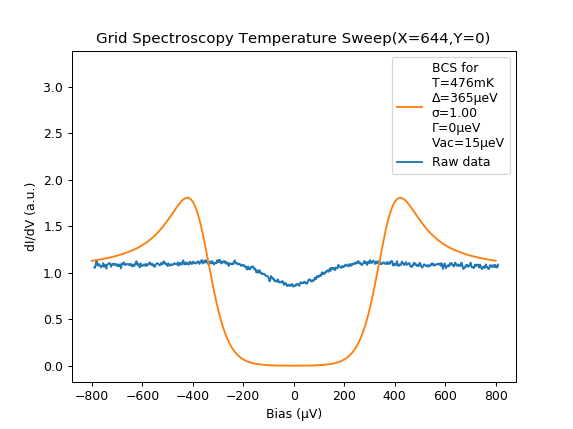

Button(description='save figure', style=ButtonStyle())

HBox(children=(Button(description='fit all', style=ButtonStyle()), Button(description='fit T', style=ButtonStyle()), Button(description='fit Δ', style=ButtonStyle()), Button(description='fit Δ + Sigma', style=ButtonStyle())))

interactive(children=(FloatSlider(value=100.0, description='T (mK)', layout=Layout(width='800px'), max=1200.0, min=50.0, readout_format='.0f', step=1.0), FloatSlider(value=1.0, description='Sigma', layout=Layout(width='800px'), max=1.5, min=0.9, step=0.001), FloatSlider(value=365.0, description='Delta (ueV)', layout=Layout(width='800px'), max=400.0, readout_format='.0f', step=1.0), FloatSlider(value=15.0, description='Vac rms (uV)', layout=Layout(width='800px'), max=30.0, min=1.0, readout_format='.0f', step=1.0), FloatSlider(value=-4.404404293139813, description='offset (uV)', layout=Layout(width='800px'), min=-100.0, readout_format='.1f'), FloatSlider(value=0.0, description='Γ (uV)', layout=Layout(width='800px'), max=30.0, readout_format='.0f', step=1.0), IntSlider(value=0, description='x', layout=Layout(width='800px'), max=1999), IntSlider(value=0, description='y', layout=Layout(width='800px'), max=0), Output()), _dom_classes=('widget-interact',))

In [7]:
%matplotlib notebook
from pathlib import Path
d = Path().resolve().parent
import sys
sys.path.insert(1, str(d))
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display
from ipywidgets import Button, interact, widgets, Layout, HBox
from NanonisMeasurement import NanGridSpectroscopy
from SuperconductingSample import NIS

### Options 
max_T       = 1.2 # K
Delta_min   = 0 # eV
Delta_max   = 400e-6 # eV

### initial parameter
T           = 0.1 # K
Sigma       = 1 # a.u.
Vacrms      = 15e-6 # V
offset      = 0
Gamma       = 0
Delta       = 365e-6 # eV
x_ind       = 0 # index in grid
y_ind       = 0 # index in grid

### open a file dialog for selecting the data file
import tkinter as tk
from tkinter import filedialog
root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename()

### Load the data
GS      = NanGridSpectroscopy(filename=file_path)
BS      = GS.get_spectrum(x_ind,y_ind)
BS_dIdV = BS.get_dIdV()
BS_dIdV = (1/NIS.get_normal_state_conductance(BS_dIdV))*BS_dIdV

left_peak,right_peak = NIS.get_coherence_peaks(BS_dIdV)
offset  = (right_peak[0]+left_peak[0])/2

### Prepare the plot
fig,ax = plt.subplots()
ax.set_xlabel('Bias (µV)')
ax.set_ylabel('dI/dV (a.u.)')
ax.set_title(BS.title)
# Plot spectrum in the background
x, y_BS     = BS_dIdV.get_x_y()
line_BS,    = ax.plot(x*1e6,y_BS,label='Raw data')

# Plot the theory curve
label = lambda T,Delta,Sigma,Vacrms,Gamma: f"BCS for \nT={T*1e3:.0f}mK\nΔ={Delta*1e6:.0f}µeV\nσ={Sigma:.2f}\nΓ={Gamma*1e6:.0f}µeV\nVac={Vacrms*1e6:.0f}µeV"
y_Theory = NIS.real_dIdV(x=x,Delta=Delta,T=T,sig0=Sigma,V_ac_rms=Vacrms,Gamma=Gamma)
line_Theory, = ax.plot(x*1e6,y_Theory,label=label(T,Delta,Sigma,Vacrms,Gamma),c='tab:orange')

legend = ax.legend(bbox_to_anchor=(1, 0, 1, 1),loc='lower left')


### Make the plot interactive
def update(T=T,Sigma=Sigma,Delta=Delta,Vac=Vacrms,offset=offset,Gamma=Gamma,x_ind=x_ind,y_ind=y_ind):
    global factors,GS,BS_dIdV,BS
    line_Theory.set_ydata(NIS.real_dIdV(
                            x = x,
                            sig0 = Sigma,
                            Delta = Delta/factors['Delta'],
                            T=T/factors['T'],
                            V_ac_rms=Vac/factors['Vac'],
                            Gamma=Gamma/factors['Gamma']))
    ax.legend([line_Theory,line_BS],[label(T/factors['T'],Delta/factors['Delta'],
                                    Sigma/factors['Sigma'],Vac/factors['Vac'],Gamma/factors['Gamma']),
                                     'Raw data'])
    line_BS.set_xdata(x*1e6-offset)
    BS      = GS.get_spectrum(x_ind,y_ind)
    BS_dIdV = BS.get_dIdV()
    BS_dIdV = (1/NIS.get_normal_state_conductance(BS_dIdV))*BS_dIdV
    line_BS.set_ydata(BS_dIdV.get_y())
    
    ax.set_title(BS.title)
    fig.canvas.draw_idle()

    
### Create buttons and their functionalities
def save_figure(b):
    title=file_path[:-4] +"-BCS fit.png"
    fig.savefig(title, dpi='figure', format="png")
b_savefig = Button(description="save figure")
display(b_savefig)
b_savefig.on_click(save_figure)

def set_values(fit_result):
    if fit_result is not None:
        global widgets,factors
        widgets['T'].value      = fit_result.T*factors['T']
        widgets['Sigma'].value  = fit_result.sig0*factors['Sigma']
        widgets['Delta'].value  = fit_result.Delta*factors['Delta']
        widgets['Gamma'].value  = fit_result.Gamma*factors['Gamma']
        widgets['Vac'].value    = fit_result.V_ac_rms*factors['Vac']

def fit(fit_func,kwargs):
    global widgets, factors, BS_dIdV
    offset = widgets['offset'].value*1e-6
    spec = deepcopy(BS_dIdV).apply_transformation(lambda x,y: (x-offset,y))
    try: 
        return fit_func(spec,**kwargs)    
    except:
        return None

def fit_all(b):
    global BS_dIdV, widgets, factors
    res = fit(NIS.fit,dict(
        Delta_guess = widgets['Delta'].value/factors['Delta'],
        sig0_guess  = widgets['Sigma'].value/factors['Sigma'],
        T_guess     = widgets['T'].value/factors['T'],
        V_ac_rms    = widgets['Vac'].value/factors['Vac'],
        Gamma_guess = widgets['Gamma'].value/factors['Gamma']
    ))
    set_values(res)
    
b_fit_all = Button(description="fit all")
b_fit_all.on_click(fit_all)

def fit_T(b):
    global BS_dIdV, widgets, factors                                          
    res = fit(NIS.fit_T,dict(
            Delta       = widgets['Delta'].value/factors['Delta'],
            sig0        = widgets['Sigma'].value/factors['Sigma'],
            T_guess     = widgets['T'].value/factors['T'],
            V_ac_rms    = widgets['Vac'].value/factors['Vac'],
            Gamma       = widgets['Gamma'].value/factors['Gamma']
    ))
    set_values(res)
    
b_fit_T = Button(description="fit T")
b_fit_T.on_click(fit_T)

def fit_Delta(b):
    global BS_dIdV, widgets, factors
    res = fit(NIS.fit_Delta,dict(
        Delta_guess = widgets['Delta'].value/factors['Delta'],
        sig0        = widgets['Sigma'].value/factors['Sigma'],
        T           = widgets['T'].value/factors['T'],
        V_ac_rms    = widgets['Vac'].value/factors['Vac'],
        Gamma       = widgets['Gamma'].value/factors['Gamma']
    ))
    set_values(res)
    
b_fit_Delta = Button(description="fit Δ")
b_fit_Delta.on_click(fit_Delta)

def fit_Delta_sigma(b):
    global BS_dIdV, widgets, factors
    res = fit(NIS.fit_Delta_sigma,dict(
        Delta_guess = widgets['Delta'].value/factors['Delta'],
        sig_guess   = widgets['Sigma'].value/factors['Sigma'],
        T           = widgets['T'].value/factors['T'],
        V_ac_rms    = widgets['Vac'].value/factors['Vac'],
        Gamma       = widgets['Gamma'].value/factors['Gamma']
    ))
    set_values(res)
    
b_fit_Delta_sigma = Button(description="fit Δ + Sigma")
b_fit_Delta_sigma.on_click(fit_Delta_sigma)

display(HBox([b_fit_all,b_fit_T,b_fit_Delta,b_fit_Delta_sigma]))

### Create sliders to adjust the fit values manually
factors = {'T':1e3,'Sigma':1,'Delta':1e6,'Vac':1e6,'offset':1e6,'Gamma':1e6}
widgets = {
        'T':widgets.FloatSlider(     min=50,                            max=max_T*factors['T'],         step=1,     value=T*factors['T'],           readout_format='.0f',layout=Layout(width='800px'),description='T (mK)'),
        'Sigma':widgets.FloatSlider( min=0.9,                           max=1.5,                        step=1e-3,  value=Sigma**factors['Sigma'],  readout_format='.2f',layout=Layout(width='800px')),
        'Delta':widgets.FloatSlider( min=Delta_min*factors['Delta'],    max=Delta_max*factors['Delta'], step=1,     value=Delta*factors['Delta'],   readout_format='.0f',layout=Layout(width='800px'),description='Delta (ueV)'),
        'Vac':widgets.FloatSlider(   min=1,                             max=30,                         step=1,     value=Vacrms*factors['Vac'],    readout_format='.0f',layout=Layout(width='800px'),description='Vac rms (uV)'),
        'offset':widgets.FloatSlider(min=-100,                          max=100,                        step=0.1,   value=offset*factors['offset'], readout_format='.1f',layout=Layout(width='800px'),description='offset (uV)'),
        'Gamma':widgets.FloatSlider( min=0,                             max=30,                         step=1,     value=Gamma*factors['Gamma'],   readout_format='.0f',layout=Layout(width='800px'),description='Γ (uV)'),
        'x_ind':widgets.IntSlider(   min=0,                             max=GS.pts_x-1,                 step=1,     value=x_ind                                         ,layout=Layout(width='800px'),description='x'),
        'y_ind':widgets.IntSlider(   min=0,                             max=GS.pts_y-1,                 step=1,     value=y_ind                                         ,layout=Layout(width='800px'),description='y')
}

### start the interactive plot
interact(update,
        **widgets,
        b=b_savefig);

### Try fitting the curve so the user has as little work as possible
fit_all(None)